# GPS単体の測位結果を用いて近似曲線を引くプログラム

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Math
import openpyxl
import itertools
from decimal import Decimal,ROUND_HALF_UP
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from tqdm import tqdm
import tendline
import os

In [2]:
"""DataFrameの成型"""

def DataFrame(df,x,y):
    y_ave=np.zeros((len(y),1))
    
    #DataFrame_空白行削除 x,y更新
    print("空白行の削除中")
    for i in tqdm(range(len(df)-1,-1,-1)):
      k=1
      for j in range(len(df.columns)):
        if pd.isna(df.iloc[i,j])==True:
            k+=1
            if k==len(df.columns):
               x.drop(index=i,inplace=True)
               y.drop(index=i,inplace=True)

    x.reset_index(inplace=True,drop=True)
    y.reset_index(inplace=True,drop=True)

    #DataFrame_空白列削除 x,y更新
    #EL：yにおいて、ある列すべての要素(疑似距離残差)がNanの場合、その列と、xにおいて対応する列を削除
    if len(x.columns)==len(y.columns):
      print("空白列の削除中")
      for j in tqdm(range(len(y.columns)-1,-1,-1)):
        k=1
        for i in range(len(y)):
          if pd.isna(y.iloc[i,j])==True:
             k+=1
             if k==len(y):
                x.drop(columns=x.columns[j],inplace=True)
                y.drop(columns=y.columns[j],inplace=True)

    #DOP,NSAT：yにおいて、エポックごとの各衛星の疑似距離残差の平均を取る(Nanはスキップ)
    else:
      print("疑似距離残差の平均値を計算中")
      for i in tqdm(range(len(y))):
        y_ave[i,0]=y.iloc[i].abs().sum(skipna=True)
        y_ave[i,0]=y_ave[i,0]/(y.count(axis=1).iloc[i])
    
    return (x,y,y_ave)

In [3]:
"""
データ準備_X:特徴量
データ準備_Y:疑似距離残差
"""

def array_data(x,y,y_ave):
    #X_EL:要素が0以下、またはNanの場合Nanを返し、それ以外は四捨五入して整数に丸める
    if len(x.columns)==len(y.columns):
      print("Xデータの成型中_EL")
      for i in tqdm(range(len(x))):
        for j in range(len(x.columns)):
          if x.iloc[i,j]<0 or pd.isna(x.iloc[i,j])==True:
             x.iloc[i,j]=None
          else:
             x.iloc[i,j]=Decimal(str(x.iloc[i,j])).quantize(Decimal("0"),rounding=ROUND_HALF_UP)

    #X_DOP：要素がNanの場合はNanを返し、それ以外は四捨五入して少数第2位までに丸める
    elif len(x.columns)==5:
      print("Xデータの成型中_DOP")
      for i in tqdm(range(len(x))):
        for j in range(len(x.columns)):
          if pd.isna(x.iloc[i,j])==True:
             x.iloc[i,j]=None
          else:
             x.iloc[i,j]=Decimal(str(x.iloc[i,j])).quantize(Decimal("0.01"),rounding=ROUND_HALF_UP)

    #X_NSAT:要素がNanの場合はNanを返し、それ以外はそのままの値を返す
    else:
      print("Xデータの成型中_NSAT")
      for i in tqdm(range(len(x))):
        for j in range(len(x.columns)):
          if pd.isna(x.iloc[i,j])==True:
             x.iloc[i,j]=None
          else:
             x.iloc[i,j]=x.iloc[i,j]

    #Y_EL：要素がNanの場合はNanを返し、それ以外は絶対値を返す
    if len(x.columns)==len(y.columns):
       print("Yデータの成型中_EL")
       for i in tqdm(range(len(y))):
         for j in range(len(y.columns)):
           if y.iloc[i,j]<0:
              y.iloc[i,j]=(-1)*y.iloc[i,j]
           elif pd.isna(y.iloc[i,j])==True:
              y.iloc[i,j]=None
           else:
              y.iloc[i,j]=y.iloc[i,j]

    #Y_DOP or NSAT：疑似距離残差の平均を返す
    else:
      print("Yデータの成型中_DOP or NSAT")
      for i in tqdm(range(len(y))):
          y.iloc[i,0]=y_ave[i,0]
      y.drop(columns=y.columns[[range(1,len(y.columns),1)]],inplace=True)
      y.columns=["range_residual_ave"]
    
    #結果出力用のDataFrame
    df3=pd.concat([x,y],axis=1)

    return (x,y,df3)

In [4]:
"""RMS算出"""

def RMS(x,y):
        
    rms=np.zeros((len(x),1))
    
    #RMS_NSAT
    if len(x.columns)==1 and len(y.columns)==1:
      X="NSAT"
      print("RMS算出中_NSAT")

      param_max=int(input("param_maxを入力してください(ex/param_max=32,stepは1で固定)"))
      residual_max=int(input("residual_maxを設定しますか？(No=0,Yes=設定したいresidual_maxの値)"))

      step=1
      for param in tqdm(np.arange(0,param_max,step)):
        k=0
        l=0
        for i in range(len(x)):
          if pd.isna(y.iloc[i,0])==False and x.iloc[i,0]==param: 
              k+=1
              l+=pow(y.iloc[i,0],2)
              rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=np.sqrt(l/k)
          elif k==0:
              rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=0

    #RMS_DOP
    elif len(x.columns)==5 and len(y.columns)==1:
      print("RMS算出中_DOP")

      DOP=int(input("DOPを選択してください(G=0,P=1,H=2,V=3,T=4)"))
      print("param_maxとstepを入力してください(ex/param_max=4.5,step=0.01)")
      param_max,step=map(float,input().split())

      DOP_type=["G","P","H","V","T"]
        
      X="{}DOP".format(DOP_type[DOP])

      residual_max=int(input("residual_maxを設定しますか？(No=0,Yes=設定したいresidual_maxの値)"))

      for param in tqdm(np.arange(0,param_max,step)):
        k=0
        l=0
        for i in range(len(x)):
          if pd.isna(y.iloc[i,0])==False and abs(Decimal(x.iloc[i,DOP])-Decimal(str(param)))<1e-5:
              k+=1
              l+=pow(y.iloc[i,0],2)
              rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=np.sqrt(l/k)
          elif k==0:
              rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=0

    #RMS_EL
    else:
      X="EL"
      print("RMS算出中_EL")

      step=int(input("stepを入力してください(ex/step=5,param_maxは91で固定)"))

      residual_max=int(input("residual_maxを設定しますか？(No=0,Yes=設定したいresidual_maxの値)"))

      param_max=91
      for param in tqdm(range(0,param_max,step)):
        k=0
        l=0
        for i in range(len(x)):
          for j in range(len(x.columns)):
            if pd.isna(y.iloc[i,j])==False and x.iloc[i,j]==param:
                k+=1
                l+=pow(y.iloc[i,j],2)
                rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=np.sqrt(l/k)
            elif k==0:
                rms[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)),0]=0
    
    #RMSが出力される最終行+1を求める
    init=0
    if param_max%step==0:
      init=int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP))+1
    else:
      init=int(Decimal(np.ceil(param_max/step)).quantize(Decimal("0"),rounding=ROUND_HALF_UP))

    #データ整理
    rms=np.delete(rms,range(init,len(x),1),axis=0)
    x_pre=pd.DataFrame(np.arange(0,param_max,step))
    y_pre=pd.DataFrame(rms)
    
    #結果出力用のDataFrame
    df4=pd.concat([x_pre,y_pre],axis=1)
    
    #residual_maxの設定
    for param in np.arange(0,param_max,step)[::-1]:
      if residual_max==0:
         if y_pre.iloc[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP))][0]==0:
            df4=df4.drop(index=int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)))
      else:
         if y_pre.iloc[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP))][0]==0 or \
            y_pre.iloc[int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP))][0]>residual_max:
            df4=df4.drop(index=int(Decimal(param/step).quantize(Decimal("0"),rounding=ROUND_HALF_UP)))
    
    df4.columns=["{}".format(X),"疑似距離残差RMS"]
    
    #グラフ描画
    fig1=plt.figure()
    
    plt.title("range error model")
    plt.xlabel("{}".format(X))
    plt.ylabel("pseudo-range residual")
    plt.grid(True)
    
    if len(x.columns)==len(y.columns):
       plt.scatter(x,y)
    else:
       plt.scatter(x.iloc[:,DOP],y)
    
    return (rms,df4,param_max,step,residual_max,X,fig1)

In [5]:
#ファイル読み込み
df1=pd.read_csv("log.csv")
#df1.head()

In [6]:
#必要な諸量のデータ成型 df2
#x=EL:list(range(87,243,5))
#x=DOP:list(range(7,12))
#y=NSAT:16:17
#y=疑似距離残差：list(range(18,81,2))
#変更する箇所(特徴量の選択)
x=df1.iloc[:,list(range(7,12))].copy()
y=df1.iloc[:,list(range(18,81,2))].copy()
chain=itertools.chain(x,y)
df2=df1.loc[:,list(chain)]
#df2.head()

In [7]:
#DataFrameの成型
x,y,y_ave=DataFrame(df2,x,y)
#データの準備
x,y,df3=array_data(x,y,y_ave)
#df3.head()

  0%|          | 24/5231 [00:00<00:21, 237.24it/s]

空白行の削除中


  2%|▏         | 91/5127 [00:00<00:11, 437.53it/s]

疑似距離残差の平均値を計算中


  3%|▎         | 136/5127 [00:00<00:08, 561.72it/s]

Xデータの成型中_DOP


  0%|          | 0/5127 [00:00<?, ?it/s]

Yデータの成型中_DOP or NSAT


100%|██████████| 5127/5127 [00:00<00:00, 5773.10it/s]
/Users/yuki/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


RMS算出中_DOP
DOPを選択してください(G=0,P=1,H=2,V=3,T=4)0
param_maxとstepを入力してください(ex/param_max=4.5,step=0.01)
3.0 0.01
residual_maxを設定しますか？(No=0,Yes=設定したいresidual_maxの値)0


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


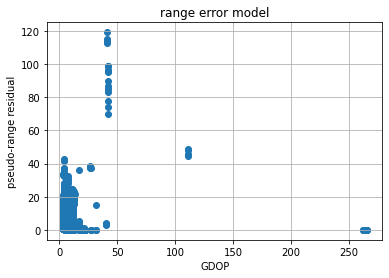

In [8]:
#RMS算出
rms,df4,param_max,step,residual_max,X,fig1=RMS(x,y)

In [9]:
#近似曲線を算出
if df4.size==0:
   print("Error!：param_maxの値が小さすぎます")

else:
   data_x,\
   data_y,data_y1,data_y2,data_y3,data_y4,data_y5,data_y6,data_y7,data_y8,data_y9,data_y10,\
   popt1,popt2,popt3,popt4,popt5,popt6,popt7,popt8,popt9,popt10\
   =tendline.tendline_all(df4)

#結果出力用のDataFrame
df5=pd.DataFrame\
([["𝑦=𝑎𝑒^𝑥",popt1],["𝑦=𝑎^𝑥",popt2],["𝑦=𝑒^(𝑎𝑥)",popt3],["𝑦=𝑎^(1/𝑥)",popt4],["𝑦=(1/𝑥)^𝑎",popt5],["𝑦=𝑎/𝑥",popt6],["𝑦=𝑎+𝑏𝑙𝑜𝑔(𝑥)",popt7],["𝑦=𝑎^(1/𝑥)+𝑏/𝑥",popt8],["𝑦=𝑎/𝑠𝑖𝑛(𝑥)",popt9],["𝑦=𝑎/𝑒^(𝑏𝑥)𝑠𝑖𝑛(𝑥)",popt10]])

df5.columns=["近似曲線","パラメータ"]

        2
-61.36 x + 383.9 x - 590.3
0.3199481035825651


<IPython.core.display.Math object>

[0.35393037]
0.12180529493492354


<IPython.core.display.Math object>

[1.89908105]
0.08143943179034607


<IPython.core.display.Math object>

[0.64137008]
0.08143943179045232


<IPython.core.display.Math object>

[192.14575661]
-0.09169182815531873


<IPython.core.display.Math object>

[-1.74638049]
0.07715212396839277


<IPython.core.display.Math object>

[18.07480455]
-0.04888994920930445


<IPython.core.display.Math object>

[-83.23880938  84.38507017]
0.31650570868259986


<IPython.core.display.Math object>

[ 0.9999769  15.18730042]
-0.04086822416968183


<IPython.core.display.Math object>

[0.31533298]
-0.04884720871670534


<IPython.core.display.Math object>

[ 9.74054202e-04 -4.05840078e+00]
0.3015817879396099


近似曲線/GPS_only/DOP/GDOPに保存しました


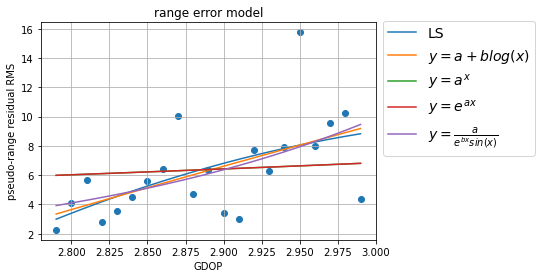

In [10]:
#近似曲線のグラフとデータを保存するディレクトリを指定
path=os.getcwd()
if X=="NSAT" or X=="EL":
  dir="近似曲線/GPS_only/{}".format(X)

  new_path=path+"/{}/residual_max".format(dir)
  os.makedirs(new_path,exist_ok=True)

else:
  dir="近似曲線/GPS_only/DOP/{}".format(X)
  
  new_path=path+"/{}/residual_max".format(dir)
  os.makedirs(new_path,exist_ok=True)

#結果を出力
if residual_max==0:
  with pd.ExcelWriter(r"{}/データ_{}_param_max={}_step={}.xlsx".format(dir,X,param_max,step,residual_max)) as writer:
    df2.to_excel(writer,index=False,sheet_name="生データ(x,y)")
    df3.to_excel(writer,index=False,sheet_name="成型後データ")
    df4.to_excel(writer,index=False,sheet_name="RMS近似曲線のデータ")
    df5.to_excel(writer,index=False,sheet_name="近似曲線のパラメータ")
else:
  with pd.ExcelWriter(r"{}/データ_{}_param_max={}_step={}_residual_max={}.xlsx".format(new_path,X,param_max,step,residual_max)) as writer:
    df2.to_excel(writer,index=False,sheet_name="生データ(x,y)")
    df3.to_excel(writer,index=False,sheet_name="成型後データ")
    df4.to_excel(writer,index=False,sheet_name="RMS近似曲線のデータ")
    df5.to_excel(writer,index=False,sheet_name="近似曲線のパラメータ")

fig2=plt.figure()

#グラフ描画
plt.title("range error model")
plt.xlabel("{}".format(X))
plt.ylabel("pseudo-range residual RMS")
plt.grid(True)
plt.scatter(df4.iloc[:,0],df4.iloc[:,1])

if X=="EL":
  #線形
  #plt.plot(data_x,data_y,label="LS")
  #plt.plot(data_x,data_y1,label=r"$y=ae^x$")
  plt.plot(data_x,data_y6,label=r"$y=\frac{a}{x}$")
  plt.plot(data_x,data_y7,label=r"$y=a+blog(x)$")
  plt.plot(data_x,data_y9,label=r"$y=\frac{a}{sin(x)}$")
  #非線形
  #plt.plot(data_x,data_y2,label=r"$y=a^x$")
  #plt.plot(data_x,data_y3,label=r"$y=e^{ax}$")
  #plt.plot(data_x,data_y4,label=r"$y=a^{\frac{1}{x}}$")
  #plt.plot(data_x,data_y5,label=r"$y=(\frac{1}{x})^a$")
  plt.plot(data_x,data_y10,label=r"$y=\frac{a}{e^{bx}sin(x)}$")
  plt.plot(data_x,data_y8,label=r"$y=a^{\frac{1}{x}}+\frac{b}{x}$")
elif X=="NSAT":
  #線形
  plt.plot(data_x,data_y,label="LS")
  plt.plot(data_x,data_y1,label=r"$y=ae^x$")
  plt.plot(data_x,data_y6,label=r"$y=\frac{a}{x}$")
  plt.plot(data_x,data_y7,label=r"$y=a+blog(x)$")
  plt.plot(data_x,data_y9,label=r"$y=\frac{a}{sin(x)}$")
  #非線形
  plt.plot(data_x,data_y2,label=r"$y=a^x$")
  plt.plot(data_x,data_y3,label=r"$y=e^{ax}$")
  plt.plot(data_x,data_y4,label=r"$y=a^{\frac{1}{x}}$")
  plt.plot(data_x,data_y5,label=r"$y=(\frac{1}{x})^a$")
  plt.plot(data_x,data_y10,label=r"$y=\frac{a}{e^{bx}sin(x)}$")
  plt.plot(data_x,data_y8,label=r"$y=a^{\frac{1}{x}}+\frac{b}{x}$")
else:
  #線形
  plt.plot(data_x,data_y,label="LS")
  #plt.plot(data_x,data_y1,label=r"$y=ae^x$")
  #plt.plot(data_x,data_y6,label=r"$y=\frac{a}{x}$")
  plt.plot(data_x,data_y7,label=r"$y=a+blog(x)$")
  #plt.plot(data_x,data_y9,label=r"$y=\frac{a}{sin(x)}$")
  #非線形
  plt.plot(data_x,data_y2,label=r"$y=a^x$")
  plt.plot(data_x,data_y3,label=r"$y=e^{ax}$")
  #plt.plot(data_x,data_y4,label=r"$y=a^{\frac{1}{x}}$")
  #plt.plot(data_x,data_y5,label=r"$y=(\frac{1}{x})^a$")
  plt.plot(data_x,data_y10,label=r"$y=\frac{a}{e^{bx}sin(x)}$")
  #plt.plot(data_x,data_y8,label=r"$y=a^{\frac{1}{x}}+\frac{b}{x}$")

plt.legend(loc="upper left",bbox_to_anchor=(1,1.04),fontsize=14)

#グラフを画像データとして保存
if residual_max==0:
  fig1.savefig(r"{}/測距誤差モデル.png".format(dir),bbox_inches='tight')
  fig2.savefig(r"{}/近似曲線_{}_param_max={}_step={}.png".format(dir,X,param_max,step,residual_max),bbox_inches='tight')
  print("{}に保存しました".format(dir))
else:
  fig1.savefig(r"{}/測距誤差モデル.png".format(new_path),bbox_inches='tight')
  fig2.savefig(r"{}/近似曲線_{}_param_max={}_step={}_residual_max={}.png".format(new_path,X,param_max,step,residual_max),bbox_inches='tight')
  print("{}/residual_maxに保存しました".format(dir))